In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import datetime as dt
import scipy as sp
import os

In [2]:
os.getcwd()

'C:\\Users\\6nico\\Documents\\Académico\\Talento Tech\\Tecnico\\TalentoTech-AVD\\Proyecto'

Los datos se encuentran [aqui](https://www.kaggle.com/datasets/ruslanzalevskikh/oil-well). Hacen referencia a distintas mediciones de un mismo pozo petrolero en Rusia. El pozo fue perforado en 2013 y cuenta con una profundidad de 2400 metros.

Estas son las variables y hacen referencia a lo siguiente:
1. **OilVol**: $\text{m}^3 / \text{día}$ el vólumen de petróleo producido
2. **VolLiq**: $\text{m}^3 / \text{día}$ la cantidad total de líquido (mezcla de petróleo, gas y agua) que el pozo produce diariamente en metros cúbicos.
3. **GasVol**: $\text{m}^3 / \text{día}$ la cantidad de gas producido por el pozo por día en metros cúbicos.
4. **WaterVol**: $\text{m}^3 / \text{día}$ Cantidad de agua extraída.
5. **WaterCut**: % El porcentaje de agua presente en el líquido extraído del pozo; es la proporción de agua en  cantidad total del líquido producido.
6. **WorkTime** Número de horas de operación al día.
7. **DnmcLvl**: $\text{m}$ es la altura a la que se encuentra el fluido dentro del pozo mientras la bomba está en funcionamiento y el pozo está produciendo.
8. **Pressure**: $\text{atm}$ es la presión del reservorio medida en atmósferas, la presión disminuye a medida que el pozo es explotado.

Máximo 20% en watercut

# Limpieza de datos

In [3]:
datos = pd.read_excel("Oil well.xlsx" )

In [4]:
datos.head()

,Oil well operation parameters (2013 - 2021 y). Well № 807,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Date,\nOil volume (m3/day),Volume of liquid (m3/day),\nGas volume (m3/day),Water volume (m3/day),Water cut (%),\nWorking hours,\nDynamic level (m),\nReservoir pressure (atm)
2,2013-01-01 00:00:00,49,70,13055,21,29,24,1819,214
3,2013-01-02 00:00:00,49,70,13055,21,29,24,1836,214
4,2013-01-03 00:00:00,49,70,13055,21,29,24,1788,214


In [5]:
datos.columns=['Fecha','OilVol','VolLiq','GasVol','WaterVol','WaterCut','WorkHours','DnmcLvl','Pressure']

In [6]:
datos.drop([0,1],inplace=True)

In [7]:
# Convierte la columna Fecha a tipo datetime
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
 
# Establece el índice del d.f. con la columna 'Date'
datos.index = datos['Fecha']
datos2 = datos.copy()

# Elimina la calumna Date del d.f.
datos.drop('Fecha',inplace=True, axis=1); datos

# Convertir todas las columnas de tipo object a numéricas
datos[datos.select_dtypes(include=['object']).columns] = datos.select_dtypes(include=['object']).apply(pd.to_numeric, errors='coerce')


In [8]:
datos.describe()

,OilVol,VolLiq,GasVol,WaterVol,WaterCut,WorkHours,DnmcLvl,Pressure
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000
mean,17.624362,59.464103,4730.146308,41.828853,70.694794,22.344675,1930.383464,157.019054
std,9.689026,18.634101,2598.888524,13.056625,9.534203,3.039553,114.543752,32.917150
min,0.000000,12.000000,4.000000,9.000000,29.000000,7.000000,1529.000000,100.000000
25%,11.000000,50.000000,3041.500000,33.000000,69.000000,22.000000,1855.000000,129.000000
50%,15.000000,58.000000,3909.000000,43.000000,73.000000,24.000000,1890.000000,157.000000
75%,22.000000,74.000000,5843.500000,50.000000,76.000000,24.000000,2008.000000,185.500000
max,49.000000,113.000000,13113.000000,99.000000,100.000000,24.000000,2137.000000,214.000000


Dado a que los datos corresponden a las mediciones diarias en cada una de las 8 variables en **UN MISMO POZO**, no es posible ajustar un modelo lineal mixto generalizado pues hay que tener al menos dos individuos o clusters. Por lo tanto debemos ajustar un modelo de series de tiempo a cada variable y caracterizar la estructura de correlación para realizar la predicción a 1 o 2 años.

In [9]:
datos.head()

,OilVol,VolLiq,GasVol,WaterVol,WaterCut,WorkHours,DnmcLvl,Pressure
Fecha,,,,,,,,
2013-01-01,49,70,13055,21,29,24,1819,214
2013-01-02,49,70,13055,21,29,24,1836,214
2013-01-03,49,70,13055,21,29,24,1788,214
2013-01-04,49,70,13055,21,29,24,1789,214
2013-01-05,44,70,11768,26,36,24,1825,214


In [10]:
print(datos.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18'],
              dtype='datetime64[ns]', name='Fecha', length=2939, freq=None)


In [11]:
datos.index.isna().sum()

0

El índice de fechas no tiene datos faltantes **NaT**, sin embargo hay saltos entre las fechas y se evidencia en la siguiente celda.

In [12]:
# Calcular las diferencias entre fechas consecutivas en el índice
saltos = datos.index.to_series().diff()

# Mostrar los saltos diferentes a 1 día
saltos_irregulares = saltos[saltos != pd.Timedelta('1 days')]
print(saltos_irregulares)

Fecha
2013-01-01      NaT
2015-06-01   2 days
Name: Fecha, dtype: timedelta64[ns]


Por lo tanto hay que crear de nuevo el índice de fechas de manera que los días sean consecutivos y no hayan saltos para posteriormente establecer la frecuencia diaria de la serie.

In [13]:
# Crear rango de fechas
fechas = pd.date_range(start='2013-01-01', periods=datos.shape[0],freq='D')
# Re indexar el DF con las fechas creadas por la línea anterior (Agregará NaNs donde no coincidan las fechas de 'datos' y 'fechas')
# Para evitar lo anterior hay que hacer uso de 'ffill' y 'bill'
datos = datos.reindex(labels=fechas).ffill().bfill()

In [14]:
# datos.to_csv('DatosLimpiosOilWell',index = True)

In [15]:
datos.index = pd.to_datetime(datos.index)

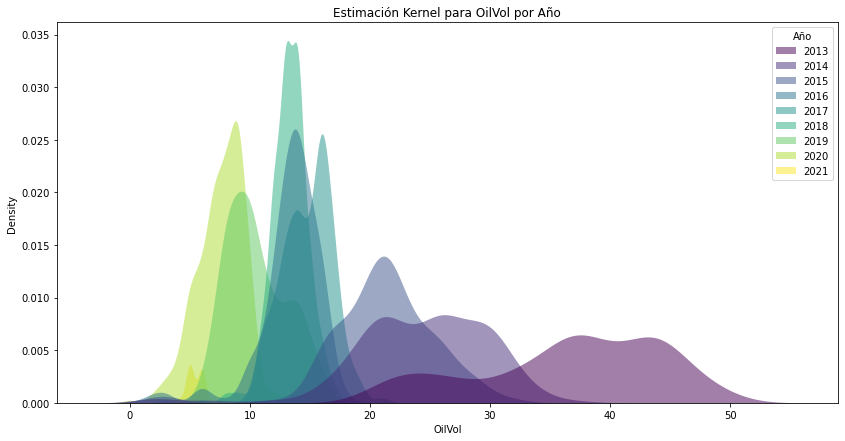

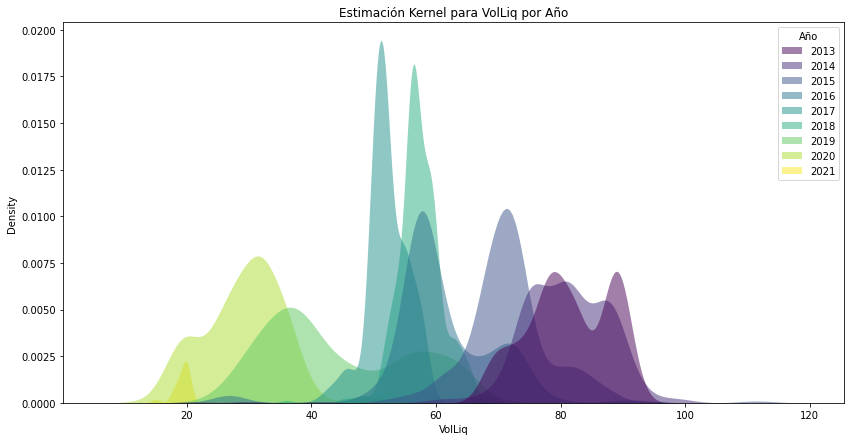

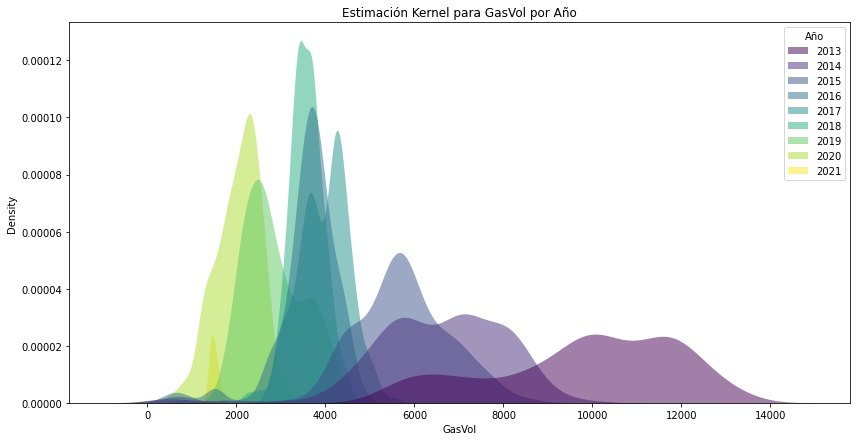

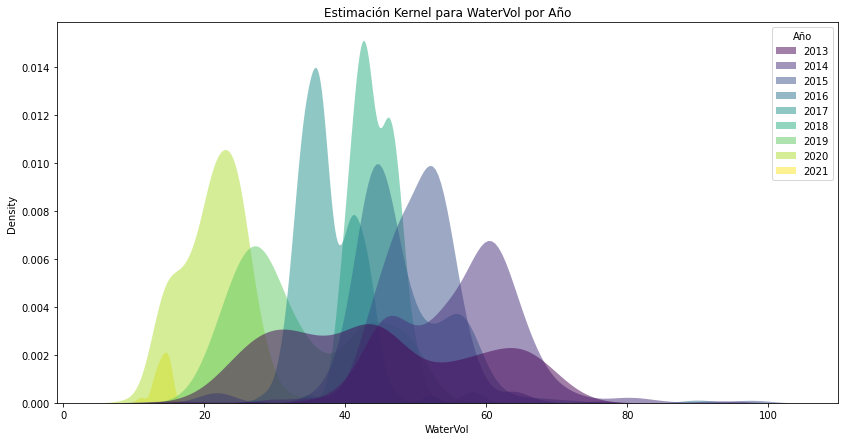

In [16]:
datos2['Año'] = datos2['Fecha'].dt.year

lista_2_plot = ['OilVol', 'VolLiq', 'GasVol', 'WaterVol']
for variable in lista_2_plot:
    fig, ax = plt.subplots(figsize=(14, 7))
    sns.kdeplot(data=datos2, x=variable, hue='Año', fill=True, alpha=0.5, linewidth=0, palette='viridis')
    ax.set_title(f'Estimación Kernel para {variable} por Año')
    plt.show()

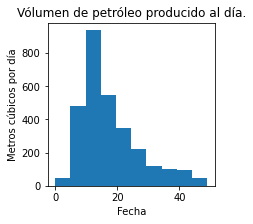

In [17]:
rcParams['figure.figsize'] = 3, 3
plt.hist(datos['OilVol'])
plt.title('Vólumen de petróleo producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

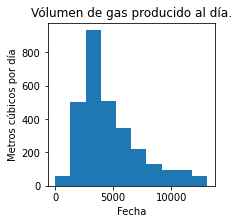

In [18]:
plt.hist(datos['GasVol'])
plt.title('Vólumen de gas producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

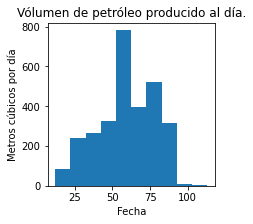

In [19]:
plt.hist(datos['VolLiq'])
plt.title('Vólumen de petróleo producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()
#

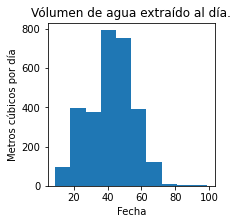

In [20]:
plt.hist(datos['WaterVol'])
plt.title('Vólumen de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

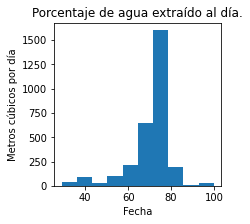

In [21]:
plt.hist(datos['WaterCut'])
plt.title('Porcentaje de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()
#

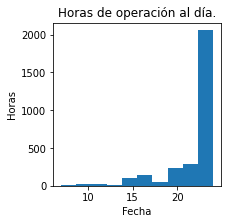

In [22]:
plt.hist(datos['WorkHours'])
plt.title('Horas de operación al día.')
plt.xlabel('Fecha')
plt.ylabel('Horas')
plt.show()
#

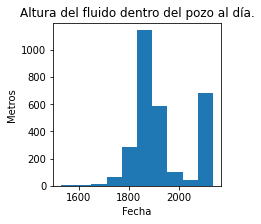

In [23]:
plt.hist(datos['DnmcLvl'])
plt.title('Altura del fluido dentro del pozo al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros')
plt.show()

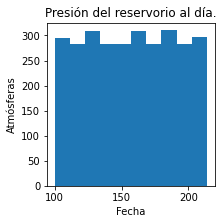

In [24]:
plt.hist(datos['Pressure'])
plt.title('Presión del reservorio al día.')
plt.xlabel('Fecha')
plt.ylabel('Atmósferas')
plt.show()

In [25]:
datos.head(2)

,OilVol,VolLiq,GasVol,WaterVol,WaterCut,WorkHours,DnmcLvl,Pressure
2013-01-01,49.0,70.0,13055.0,21.0,29.0,24.0,1819.0,214.0
2013-01-02,49.0,70.0,13055.0,21.0,29.0,24.0,1836.0,214.0


In [26]:
Pressure = datos.loc['2013-01-01':'2018-12-31','Pressure']

In [27]:
Pressure.max(); Pressure.min()

129.0

# Funciones

## Periodograma

Esta función sirve para detectar el período de una posible componente estacional determinística

In [29]:
# Función periodograma
def periodograma(serie, frecuencia = 70):
    """Serie : Introduzcar un objeto tipo series de pandas
        frecuencia(opcional): introduzca el número de indices de frecuencia que desea ver en el eje x (70 por defecto)"""
    f, Pxx_den=sp.signal.periodogram(serie)
    plt.plot(f[0:frecuencia], Pxx_den[0:frecuencia])
    for i in range(4):
        indice=np.argmax(Pxx_den, axis=0)
        print(f'El valor máximo no. {i+1} en el que se maximiza el periodograma es en el indice {indice} ')
        frecuencia_max=f[indice]
        print(f'La frecuencia es: x={frecuencia_max} con valor de periodograma y={Pxx_den[indice]} ')
        print(f'El período es: {1/frecuencia_max} días')
        print(f'Lo cual corresponde a {round(1/frecuencia_max / 30,3)} meses\n')
        f=np.delete(f,indice)
        Pxx_den=np.delete(Pxx_den,indice)
        plt.axvline(x=frecuencia_max,color='red')
    plt.show()
    return 
    

## Ajuste tendencia vía Kernel

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg

def TendKer(serie, ancho, predict_steps=0):
    """
    Esta función ajusta una regresión Kernel a la serie en función del tiempo y la gráfica.
    La regresión usa un Kernel Gaussiano y la regresión es de tipo local.
    Además, obtiene la serie sin la tendencia ajustada.
    
    Parameters:
    - serie: Objeto tipo series de pandas,
    - ancho: Ajusta el ancho de banda de la regresión, a mayor ancho menos suavidad,
    - predict_steps: Número de pasos futuros para los que se desea predecir
    
    Returns:
    - NoTendserie: Serie sin la tendencia ajustada
    - future_predictions: Predicciones de los valores futuros si predict_steps > 0
    """
    
    n = serie.shape[0]
    kde = KernelReg(endog=serie, exog=np.arange(n), var_type='c', bw=[ancho], reg_type='lc')
    
    # Fit the model to the existing data
    estimator, _ = kde.fit(np.arange(n))
    estimator = np.reshape(estimator, n)
    
    # Plot the original series and the estimated trend
    plt.plot(serie, label='Original Series')
    plt.plot(serie.index, estimator, color='red', label='Kernel Trend')
    plt.title(f'Estimación Kernel de {serie.name} con bw={ancho}')
    plt.legend()
    plt.show()
    
    # Remove trend from the series
    NoTendserie = serie - estimator
    
    # Predict future values if requested
    future_predictions = None
    if predict_steps > 0:
        future_x = np.arange(n, n + predict_steps)
        future_predictions, _ = kde.fit(future_x)
        future_predictions = np.reshape(future_predictions, predict_steps)
    return NoTendserie, future_predictions

# Ejemplo de uso:
# NoTendserie, future_pred = TendKer(your_series, ancho=5, predict_steps=10)


## Ajuste de tendencia vía LOWESS

In [31]:
def TendLOWESS (serie, prop):
    """Esta función ajusta una regresión LOWESS no robusta a la serie.
    Además obtiene la serie sin la tendencia ajustada.
        serie: Objeto tipo series de pandas
        prop: Proporción de punto que se usarán para la estimación local, a mayor proporción menos suavidad"""
    from statsmodels.nonparametric.smoothers_lowess import lowess
    n = serie.shape[0]
    lowess_serie = lowess(serie, exog= np.arange(n), is_sorted=True, frac=prop, it=0)
    # lowess obtiene una matriz; la primera columna hace referencia al índice en flotante, y la segunda a la estimación 
    y = list(zip(*lowess_serie))[1]
    NoTendserie = serie - y
    # Gráficos
    plt.plot(serie)
    plt.plot(serie.index, y, color = 'red')
    plt.title(f'Estimación LOWESS de {serie.name} con frac = {prop}')
    return NoTendserie
    

## Ajuste tendencia STL

In [219]:
def TendSTL(serie):
    ####Descomposición usando filtros
    from statsmodels.tsa.seasonal import seasonal_decompose
    from matplotlib import pyplot
    
    ###También se puede hacer vía STL###
    # Descomponer la serie de tiempo con un periodo de 365 días (para estacionalidad anual)
    result = seasonal_decompose(serie, model='additive', extrapolate_trend=6, period=365)
    
    # Graficar los resultados de la descomposición
    # desc_OilVol = result.plot()
    # pyplot.sho
    y = result.trend
    NoTendserie = serie - y
    # Gráfico
    plt.plot(serie)
    plt.plot(serie.index, y, color = 'red')
    plt.title(f'Estimación MA de {serie.name} de forma aditiva')
    return NoTendserie

# Análisis descriptivo de las series

## Volumen de petróleo

In [220]:
OilVol = datos.loc['2013-01-01':'2018-12-31','OilVol']

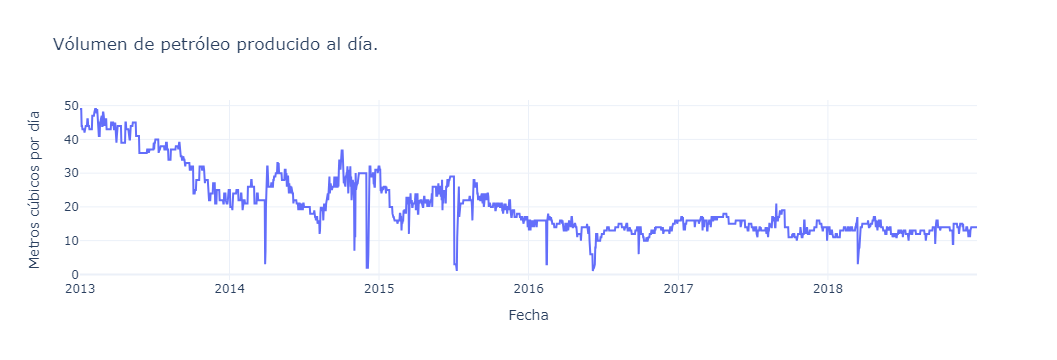

In [221]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y=OilVol)])
fig.update_layout(title_text="Vólumen de petróleo producido al día.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos por día',template = "plotly_white")


### Ajuste tendencia  

Se puede ver que la serie presenta una componente de tendencia, en particular es decreciente y tiene sentido en el contexto en que estamos.

#### STL

Vamos a usar la componente de tendencia que se estima por medio del filtro STL.

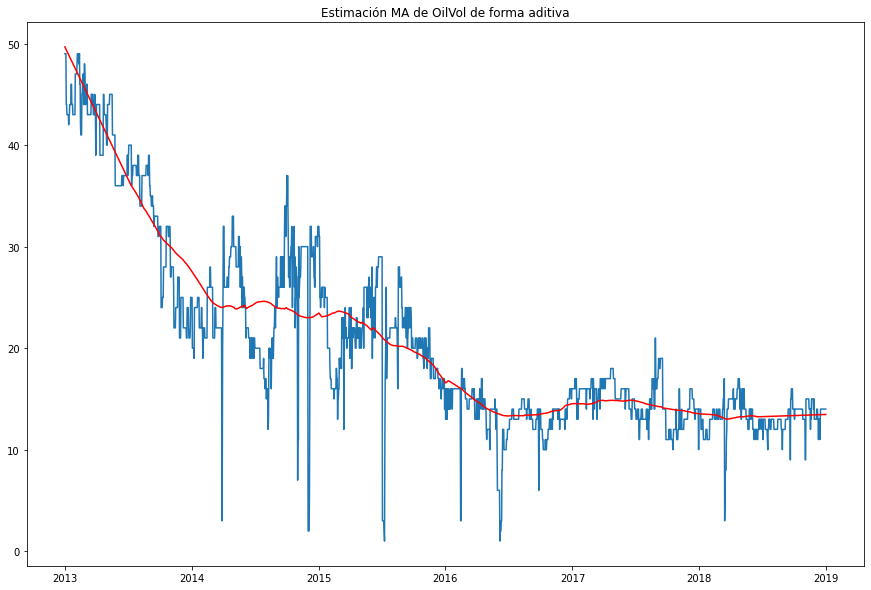

In [223]:
rcParams['figure.figsize'] = 15, 10

NoTen_OilVol_MA = TendSTL(OilVol)

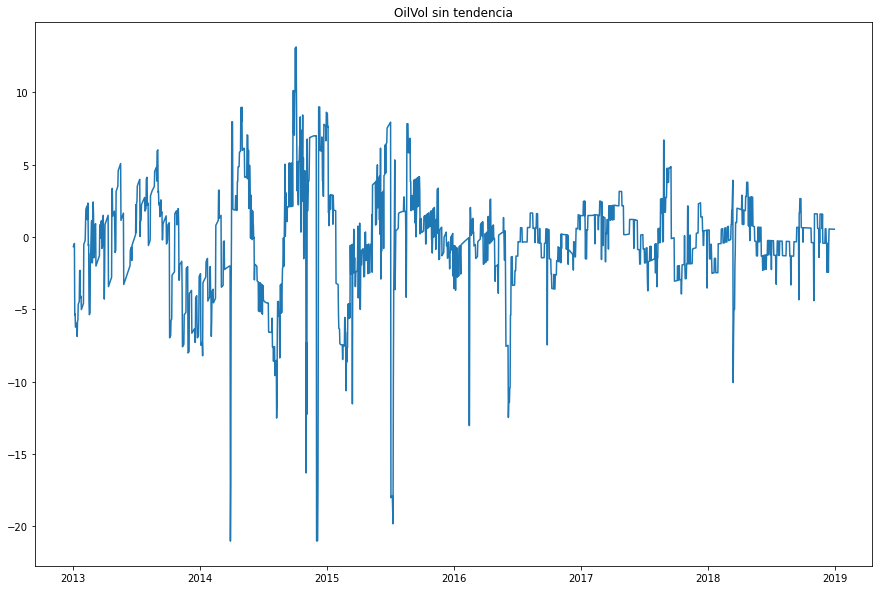

In [224]:
# Serie sin tendencia
plt.plot(NoTen_OilVol_MA)
plt.title('OilVol sin tendencia')
plt.show()

#### Kernel

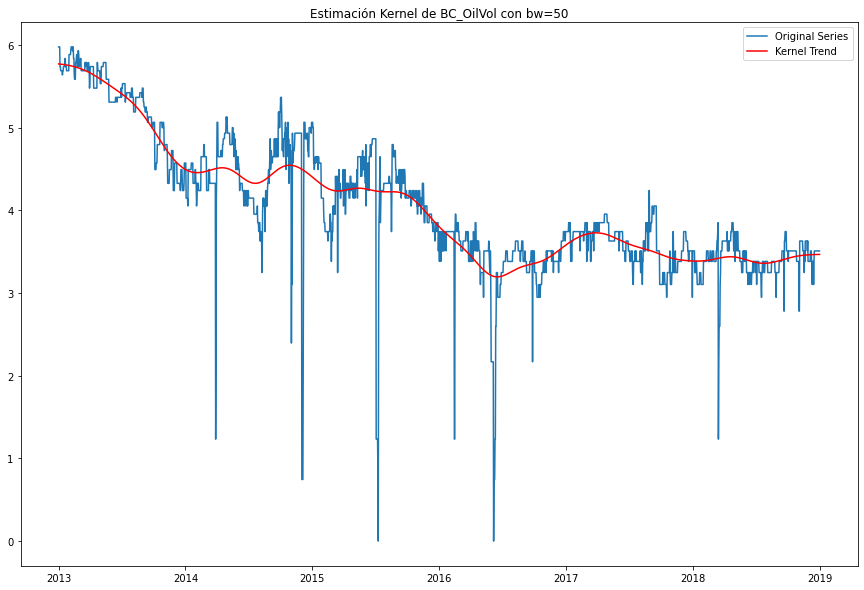

In [225]:
NoTen_OilVol_Kernel, predictedTen = TendKer(BC_OilVol,ancho=50)

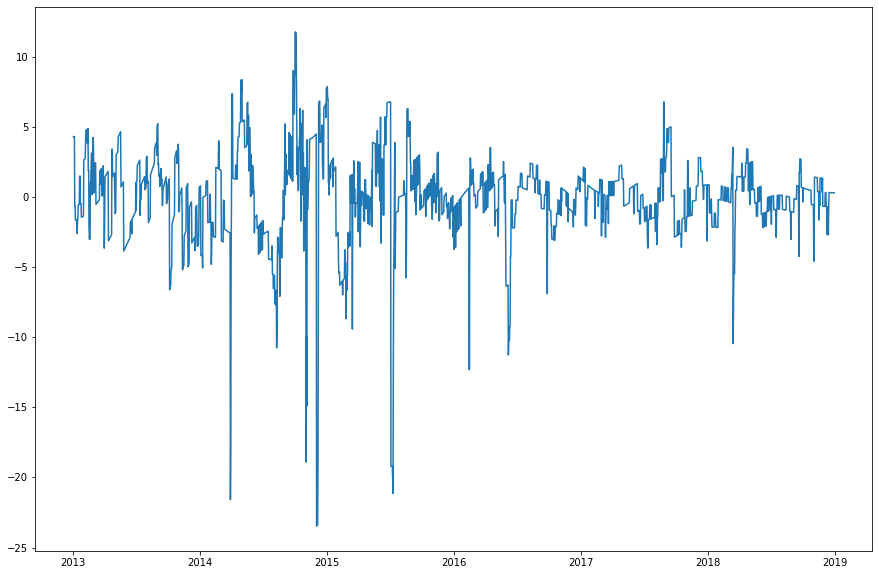

In [42]:
plt.plot(NoTen_OilVol_Kernel)

#### LOWESS

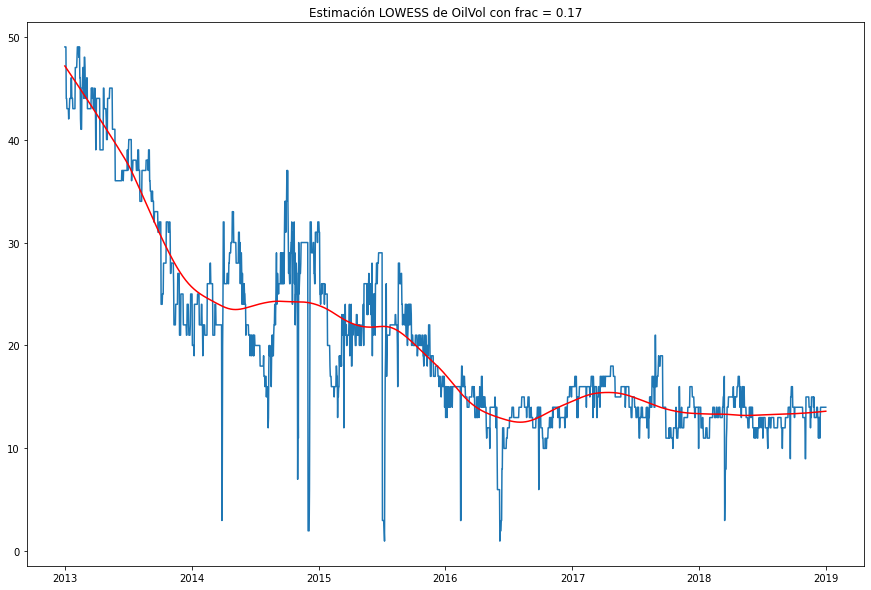

In [43]:
NoTen_OilVol_LOWESS = TendLOWESS(OilVol,prop=0.17)

### Detección estacionalidad

Se hará uso del periodograma y la función de autocorrelación para determinar si existe alguna componente estacional.

Se usará la serie sin tendencia ajustada vía Kernel, pues es la que mejor estabiliza la seria para identificar los rezagos más significativos.

El valor máximo no. 1 en el que se maximiza el periodograma es en el indice 18 
La frecuencia es: x=0.008215426745778184 con valor de periodograma y=12.443304191272393 
El período es: 121.72222222222221 días
Lo cual corresponde a 4.057 meses

El valor máximo no. 2 en el que se maximiza el periodograma es en el indice 26 
La frecuencia es: x=0.012323140118667275 con valor de periodograma y=11.036333241917278 
El período es: 81.14814814814815 días
Lo cual corresponde a 2.705 meses

El valor máximo no. 3 en el que se maximiza el periodograma es en el indice 18 
La frecuencia es: x=0.00867183934276586 con valor de periodograma y=9.09310446393316 
El período es: 115.31578947368422 días
Lo cual corresponde a 3.844 meses

El valor máximo no. 4 en el que se maximiza el periodograma es en el indice 48 
La frecuencia es: x=0.02327704244637152 con valor de periodograma y=7.97508670905061 
El período es: 42.96078431372549 días
Lo cual corresponde a 1.432 meses



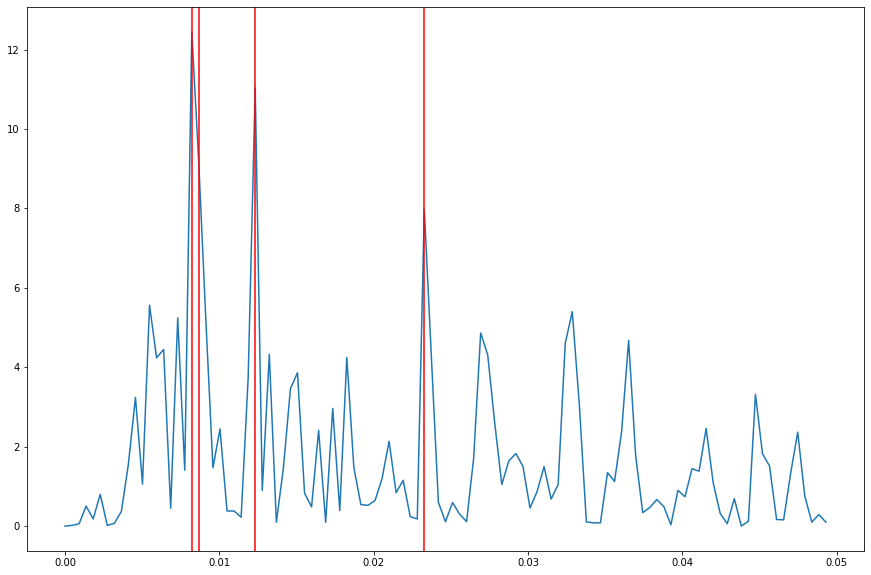

In [118]:
periodograma(NoTen_OilVol_Kernel, 109)

La serie no tiene presencia de componente estacional, pues los períodos no son armónicos y se corroboró en R con un mapa de calor. Por lo tanto las series subsecuentes tampoco tendrán esta componente

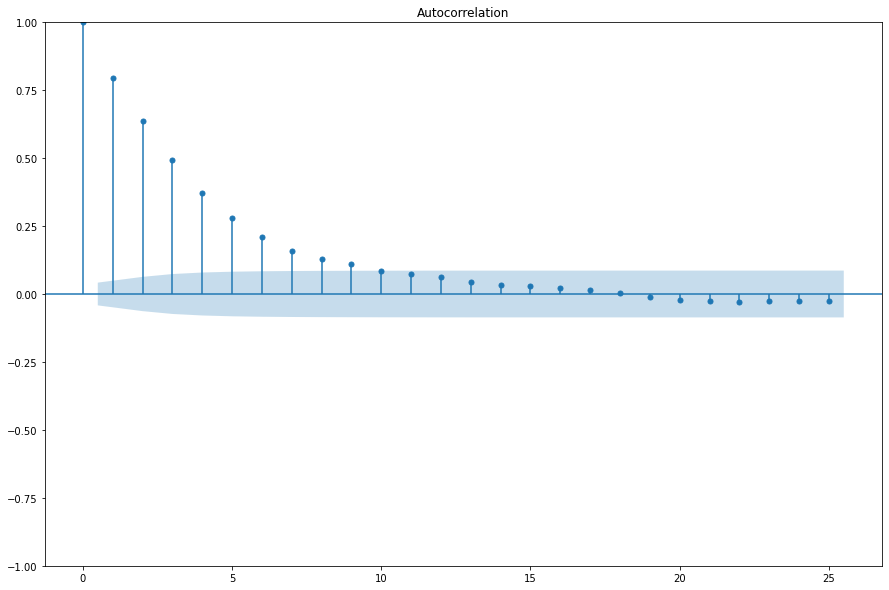

In [119]:
plot_acf(NoTen_OilVol_Kernel, lags=25)
plt.show()

Se tomarán 17 retardos de la variable para hacer la predicción de un año en una red neuronal

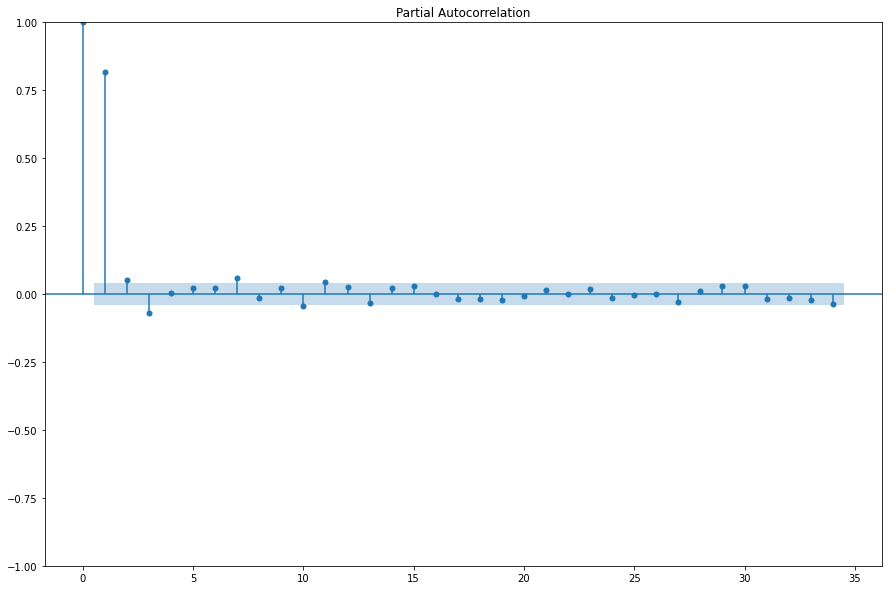

In [46]:
plot_pacf(NoTen_OilVol_Kernel)
plt.show()

La primera autocorrelación parcial es muy cercana a 1, lo cual sugiera presencia de raíz unitaria

In [52]:
np.sqrt(OilVol.shape[0])

46.8081189538738

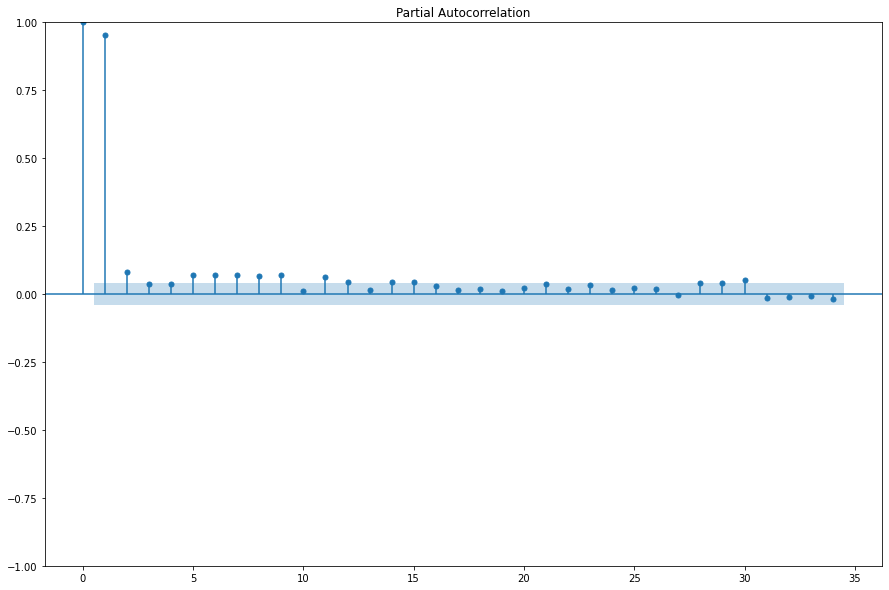

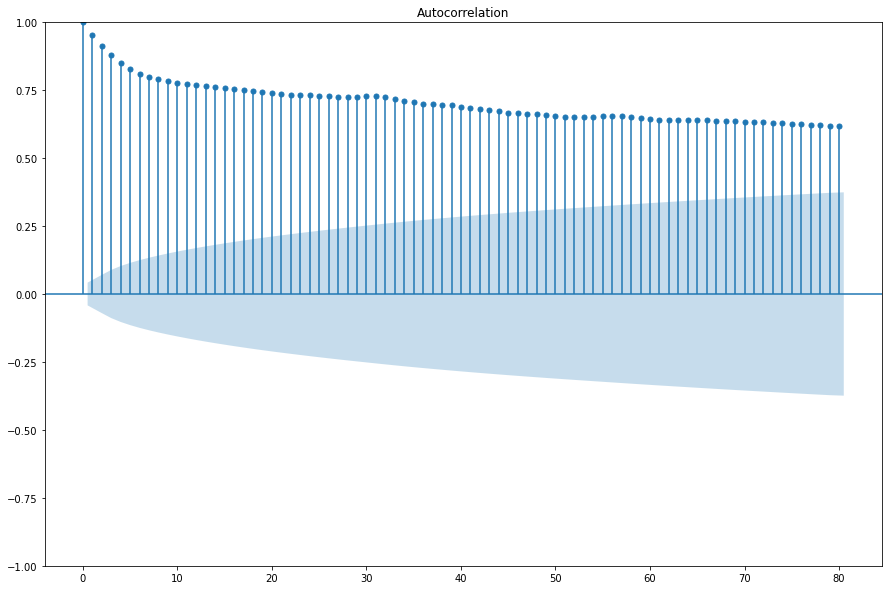

In [120]:
plot_pacf(BC_OilVol)
plot_acf(BC_OilVol,lags=80)
plt.show()

### Modelado ARIMA

Dado que la serie no tiene una componente estacional, pero si la componente de tendencia entonces vamos a ajuster un modelo ARIMA. 

Con base a la función de autocorrelación parcial de la serie sin diferenciar, vemos que el primer rezago tiene una correlación muy alta, lo cual sugiere la presencia de raíz unitaria. Se confirmará en la celda siguiente.

Primero vamos a realizar la prueba de presencia de raíz unitaria de Dickey y Fuller. 
Se considerarán los primeros 14 rezagos y una regresión con drift.

In [196]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(OilVol,maxlag=14,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(OilVol,regression="c",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -2.783880
P-value: 0.060614
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     12.52
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           1.73e-30
Time:                        12:52:32   Log-Likelihood:                -4406.2
No. Observations:                2176   AIC:                             8844.
Df Residuals:                    2160   BIC:                             8935.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0122      0.004     -2.784      0.005      -0.021      -0.004
x2            -0.1741      0.022     -8.040      0.000      -0.217      -0.132
x3            -0.0607      0.022     -2.768      0.006      -0.104      -0.018
x4            -0.1328      0.022     -6.049      0.000      -0.176      -0.090
x5            -0.1349      0.022     -6.112      0.000      -0.178      -0.092
x6            -0.1314      0.022     -5.940      0.000      -0.175      -0.088
x7            -0.1436      0.022     -6.440      0.000      -0.187      -0.100
x8            -0.0724      0.022     -3.232      0.001      -0.116      -0.028
x9            -0.0923      0.022     -4.120      0.000      -0.136      -0.048
x10           -0.0293      0.022     -1.316      0.188      -0.073       0.014
x11           -0.1080      0.022     -4.900      0.000      -0.151      -0.065
x12           -0.0708      0.022     -3.232      0.001      -0.114      -0.028
x13           -0.0140      0.022     -0.643      0.520      -0.057       0.029
x14           -0.0650      0.022     -2.994      0.003      -0.108      -0.022
x15           -0.0599      0.021     -2.800      0.005      -0.102      -0.018
const          0.2169      0.098      2.216      0.027       0.025       0.409
==============================================================================
Omnibus:                     1864.869   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           312619.091
Skew:                          -3.318   Prob(JB):                         0.00
Kurtosis:                      61.344   Cond. No.                         55.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Con una confianza del 95% no rechazamos la hipóteis nula; se confirma la presencia de raíz unitaria.
Por lo tanto se realiza la diferencia de primer orden de la serie para luego ajustar un modelo **ARMA(p,q)**

In [197]:
OilVold = OilVol.diff()
OilVold.dropna(inplace=True)

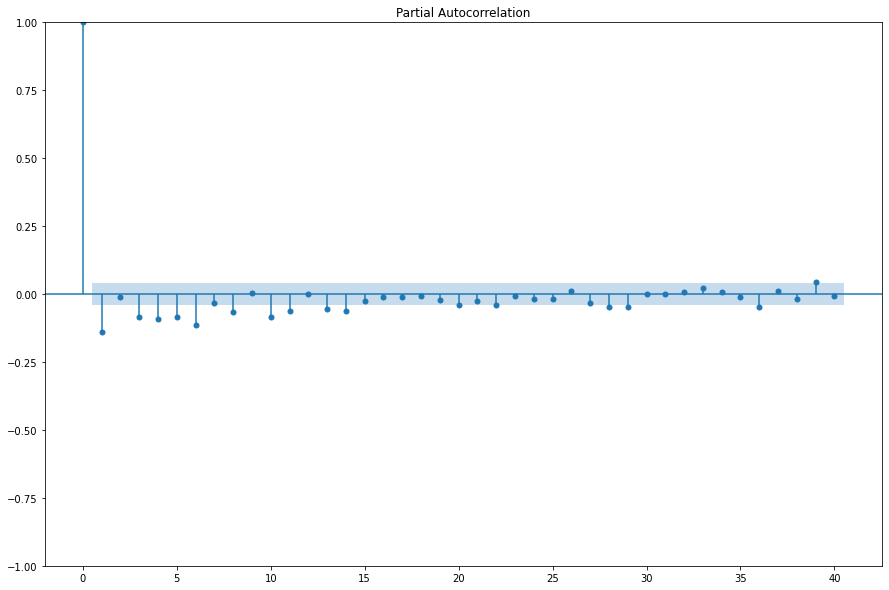

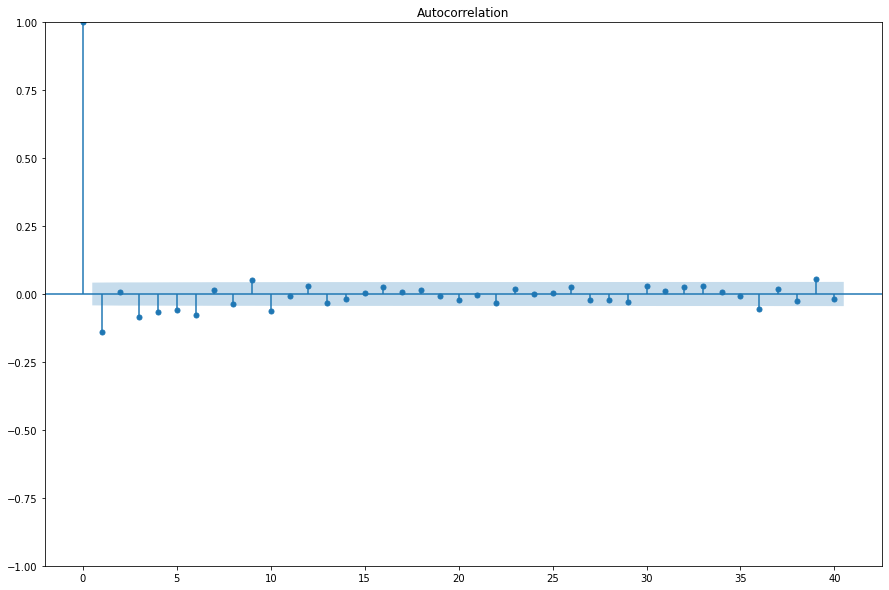

In [198]:
plot_pacf(OilVold, lags=40)
plot_acf(OilVold, lags=40)
plt.show()

Ya se puede ver que la PACF de la serie decrece muy rápido a 0. La ACF parece no mostrar signos de estacionalidad.

Se volve a realizar la prueba de Dickey y Fuller para determinar si hay que diferenciar de nuevo la serie.

In [199]:
from pmdarima.arima import auto_arima

adf = adfuller(OilVold,maxlag=14,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
adfstat, pvalue, critvalues, resstore=adfuller(OilVol,regression="c",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -16.994062
P-value: 0.000000
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     12.52
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           1.73e-30
Time:                        12:52:46   Log-Likelihood:                -4406.2
No. Observations:                2176   AIC:                             8844.
Df Residuals:                    2160   BIC:                             8935.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0122      0.004     -2.784      0.005      -0.021      -0.004
x2            -0.1741      0.022     -8.040      0.000      -0.217      -0.132
x3            -0.0607      0.022     -2.768      0.006      -0.104      -0.018
x4            -0.1328      0.022     -6.049      0.000      -0.176      -0.090
x5            -0.1349      0.022     -6.112      0.000      -0.178      -0.092
x6            -0.1314      0.022     -5.940      0.000      -0.175      -0.088
x7            -0.1436      0.022     -6.440      0.000      -0.187      -0.100
x8            -0.0724      0.022     -3.232      0.001      -0.116      -0.028
x9            -0.0923      0.022     -4.120      0.000      -0.136      -0.048
x10           -0.0293      0.022     -1.316      0.188      -0.073       0.014
x11           -0.1080      0.022     -4.900      0.000      -0.151      -0.065
x12           -0.0708      0.022     -3.232      0.001      -0.114      -0.028
x13           -0.0140      0.022     -0.643      0.520      -0.057       0.029
x14           -0.0650      0.022     -2.994      0.003      -0.108      -0.022
x15           -0.0599      0.021     -2.800      0.005      -0.102      -0.018
const          0.2169      0.098      2.216      0.027       0.025       0.409
==============================================================================
Omnibus:                     1864.869   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           312619.091
Skew:                          -3.318   Prob(JB):                         0.00
Kurtosis:                      61.344   Cond. No.                         55.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Se rechaza la hipótesis nula de presencia de raíz unitaria; no hay que diferenciar más la serie.

Se ajustará el modelo **ARMA(p,q)** a la serie de primer diferencia ordinaria.

Con base en la PACF Y ACF de la serie diferenciada podemos establecer los ordenes máximo del modelo. Para la parte AR tenemos que **p=15** y para la parte MA establecemos **q=13**

In [200]:
auto_OilVol = auto_arima(OilVold,start_p=0,d=0, start_q= 0, max_p=15, max_q=10, max_order=15,
                         seasonal=False,information_criterion='aic')

In [201]:
auto_OilVol.order

(3, 0, 1)

El "mejor" modelo ARMA que minimiza el criterio AIC resulta ser un modelo ARMA(3,1). Por lo tanto se puede establecer el modelo ARIMA(3,1,1).

In [204]:
import statsmodels.api as smapi
OilVolARIMA = smapi.tsa.SARIMAX(OilVol,order=(3,1,1),trend='c')

In [205]:
ajusteOilVol = OilVolARIMA.fit()

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Realizamos la predicción a un año con un intervalo de predicción al 95% 

In [206]:
salforecast=ajusteOilVol.get_forecast(steps=365 * 2)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticosOilVol=salforecast.predicted_mean
print(pronosticosOilVol)
print(ICforecast95)

2019-01-01    13.891607
2019-01-02    13.807195
2019-01-03    13.729747
2019-01-04    13.669218
2019-01-05    13.619957
                ...    
2020-12-26     2.844688
2020-12-27     2.829868
2020-12-28     2.815048
2020-12-29     2.800228
2020-12-30     2.785408
Freq: D, Name: predicted_mean, Length: 730, dtype: float64
            lower OilVol  upper OilVol
2019-01-01     10.289652     17.493562
2019-01-02      9.177686     18.436704
2019-01-03      8.343065     19.116429
2019-01-04      7.827835     19.510601
2019-01-05      7.466535     19.773379
...                  ...           ...
2020-12-26    -22.847686     28.537062
2020-12-27    -22.879133     28.538870
2020-12-28    -22.910570     28.540667
2020-12-29    -22.941996     28.542453
2020-12-30    -22.973411     28.544228

[730 rows x 2 columns]


In [238]:
pronosticosOilVol[pronosticosOilVol>6]

2019-01-01    13.891607
2019-01-02    13.807195
2019-01-03    13.729747
2019-01-04    13.669218
2019-01-05    13.619957
                ...    
2020-05-23     6.060627
2020-05-24     6.045807
2020-05-25     6.030987
2020-05-26     6.016167
2020-05-27     6.001348
Freq: D, Name: predicted_mean, Length: 513, dtype: float64

In [237]:
datos.loc['2019-01-1':'2020-12-30','OilVol']

2019-01-01    14.0
2019-01-02    14.0
2019-01-03    14.0
2019-01-04    14.0
2019-01-05    14.0
              ... 
2020-12-26     4.0
2020-12-27     5.0
2020-12-28     4.0
2020-12-29     5.0
2020-12-30     5.0
Freq: D, Name: OilVol, Length: 730, dtype: float64

In [218]:
np.mean( (datos.loc['2019-01-1':'2020-12-30','OilVol'] - pronosticosOilVol.shape[0])**2 )

720.9487632128113

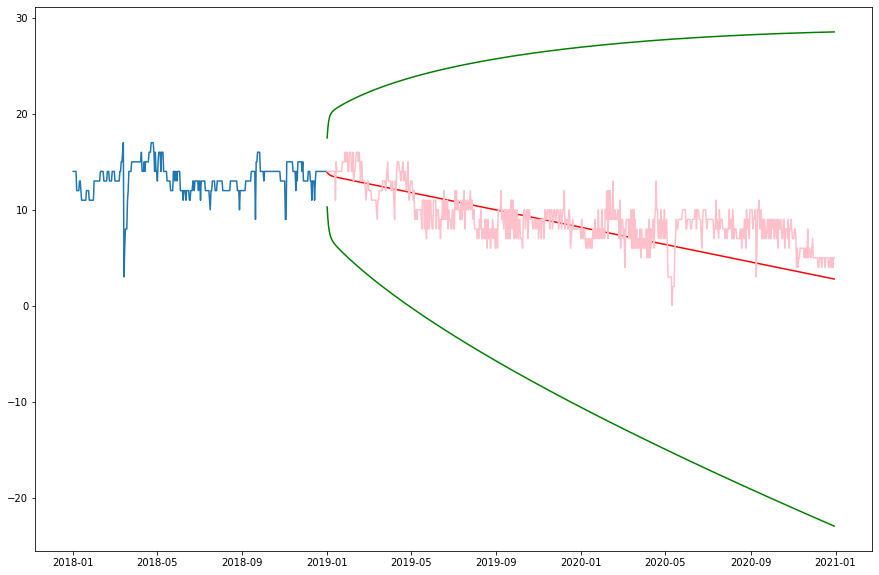

In [210]:
plt.plot(OilVol[-365:])
plt.plot(pronosticosOilVol, color='red')
plt.plot(ICforecast95['lower OilVol'],color='green')
plt.plot(ICforecast95['upper OilVol'], color='green')
plt.plot(datos.loc['2019-01-1':'2020-12-30','OilVol'], color = 'pink')


In [239]:
print(ajusteOilVol.summary())

                               SARIMAX Results                                
Dep. Variable:                 OilVol   No. Observations:                 2191
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -4440.414
Date:                Fri, 01 Nov 2024   AIC                           8892.828
Time:                        13:42:45   BIC                           8926.978
Sample:                    01-01-2013   HQIC                          8905.309
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0035      0.003     -1.127      0.260      -0.010       0.003
ar.L1          0.7461      0.014     54.800      0.000       0.719       0.773
ar.L2          0.1008      0.013      8.049      0.0

## Volumen de gas producido

In [264]:
GasVol = datos.loc['2013-01-01':'2018-12-31','GasVol']

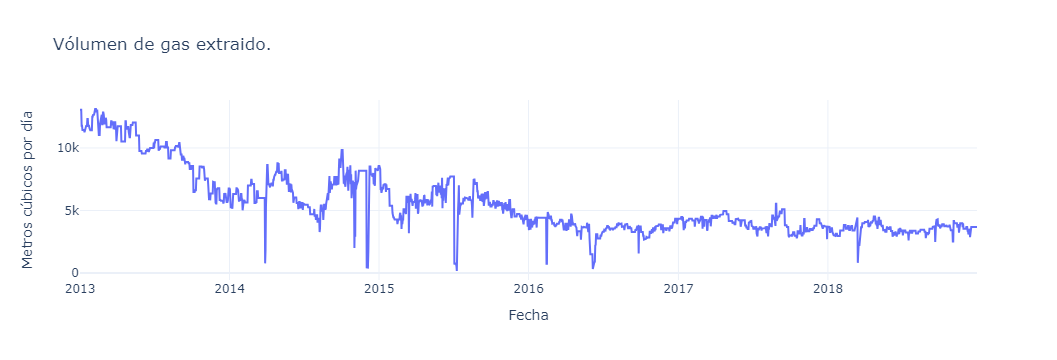

In [265]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y= GasVol)])
fig.update_layout(title_text="Vólumen de gas extraido.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos por día',template = "plotly_white")


### Modelado ARIMA

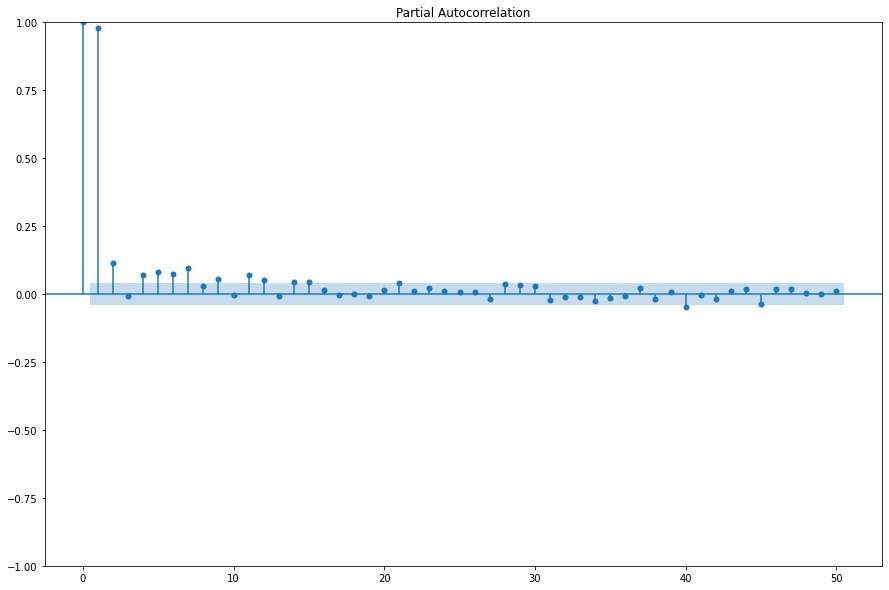

In [266]:
plot_pacf(GasVol,lags=50)
plt.show()

A lo más 15 rezagos pueden ser significativos para la parte auto regresiva!

In [267]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(GasVol,maxlag=14,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(GasVol,regression="c",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -2.764874
P-value: 0.063469
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     12.16
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           1.82e-29
Time:                        14:21:27   Log-Likelihood:                -16565.
No. Observations:                2176   AIC:                         3.316e+04
Df Residuals:                    2160   BIC:                         3.325e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0120      0.004     -2.765      0.006      -0.021      -0.003
x2            -0.1717      0.022     -7.928      0.000      -0.214      -0.129
x3            -0.0543      0.022     -2.477      0.013      -0.097      -0.011
x4            -0.1327      0.022     -6.048      0.000      -0.176      -0.090
x5            -0.1233      0.022     -5.589      0.000      -0.167      -0.080
x6            -0.1322      0.022     -5.985      0.000      -0.176      -0.089
x7            -0.1423      0.022     -6.394      0.000      -0.186      -0.099
x8            -0.0758      0.022     -3.388      0.001      -0.120      -0.032
x9            -0.0894      0.022     -4.001      0.000      -0.133      -0.046
x10           -0.0319      0.022     -1.437      0.151      -0.075       0.012
x11           -0.1036      0.022     -4.708      0.000      -0.147      -0.060
x12           -0.0701      0.022     -3.200      0.001      -0.113      -0.027
x13           -0.0127      0.022     -0.585      0.559      -0.055       0.030
x14           -0.0672      0.022     -3.095      0.002      -0.110      -0.025
x15           -0.0592      0.021     -2.765      0.006      -0.101      -0.017
const         57.5242     26.147      2.200      0.028       6.248     108.800
==============================================================================
Omnibus:                     1940.108   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           366817.224
Skew:                          -3.517   Prob(JB):                         0.00
Kurtosis:                      66.216   Cond. No.                     1.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

No se rechaza la hipótesis nula de raíz unitaria. Se diferncia la serie.

In [268]:
GasVold = GasVol.diff()
GasVold.dropna(inplace=True)

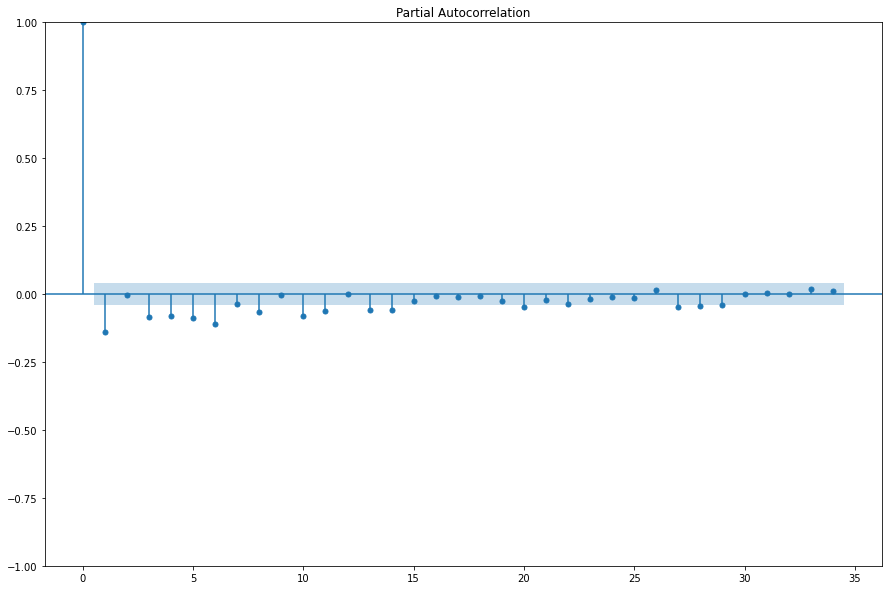

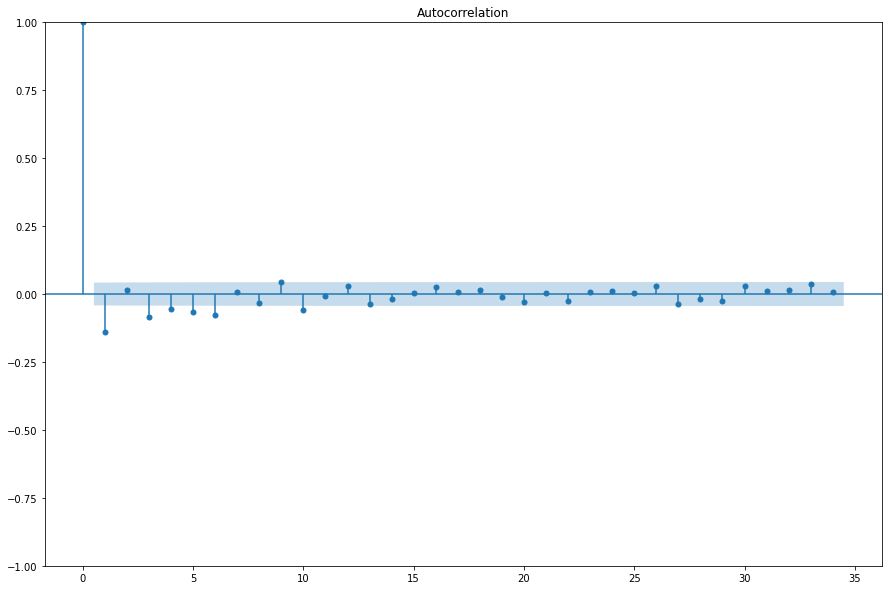

In [269]:
plot_pacf(GasVold)
plot_acf(GasVold)
plt.show()

In [270]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(GasVold,maxlag=14,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(GasVold,regression="c",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -16.952915
P-value: 0.000000
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     210.4
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:21:34   Log-Likelihood:                -16561.
No. Observations:                2175   AIC:                         3.315e+04
Df Residuals:                    2159   BIC:                         3.324e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.3927      0.141    -16.953      0.000      -2.670      -2.116
x2             1.2111      0.135      8.972      0.000       0.946       1.476
x3             1.1474      0.128      8.947      0.000       0.896       1.399
x4             1.0069      0.121      8.291      0.000       0.769       1.245
x5             0.8749      0.114      7.689      0.000       0.652       1.098
x6             0.7338      0.106      6.937      0.000       0.526       0.941
x7             0.5850      0.098      5.989      0.000       0.393       0.777
x8             0.5019      0.089      5.656      0.000       0.328       0.676
x9             0.4060      0.080      5.098      0.000       0.250       0.562
x10            0.3664      0.070      5.230      0.000       0.229       0.504
x11            0.2558      0.061      4.205      0.000       0.137       0.375
x12            0.1796      0.052      3.476      0.001       0.078       0.281
x13            0.1611      0.042      3.795      0.000       0.078       0.244
x14            0.0903      0.033      2.721      0.007       0.025       0.155
x15            0.0250      0.021      1.164      0.245      -0.017       0.067
const         -8.8466     10.567     -0.837      0.403     -29.569      11.876
==============================================================================
Omnibus:                     1954.772   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           372694.560
Skew:                          -3.564   Prob(JB):                         0.00
Kurtosis:                      66.731   Cond. No.                     1.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [271]:
auto_GasVol = auto_arima(GasVold,start_p=0,d=0, start_q= 0, max_p=14, max_q=10, max_order=14,
                         seasonal=False,information_criterion='aic')

In [272]:
auto_OilVol.order

(3, 0, 1)

El "mejor" modelo ARMA que minimiza el criterio AIC resulta ser un modelo ARMA(3,1). Por lo tanto se puede establecer el modelo ARIMA(3,1,1).

In [273]:
import statsmodels.api as smapi
GasVolARIMA = smapi.tsa.SARIMAX(GasVol,order=(3,1,1),trend='c')

In [274]:
ajusteGasVol = GasVolARIMA.fit()

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [275]:
salforecast=ajusteGasVol.get_forecast(steps=365 * 2)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticosGasVol=salforecast.predicted_mean
print(pronosticosGasVol)
print(ICforecast95)

2019-01-01    3660.648264
2019-01-02    3642.262957
2019-01-03    3625.200036
2019-01-04    3611.747165
2019-01-05    3600.686036
                 ...     
2020-12-26     887.948921
2020-12-27     884.212599
2020-12-28     880.476277
2020-12-29     876.739955
2020-12-30     873.003633
Freq: D, Name: predicted_mean, Length: 730, dtype: float64
            lower GasVol  upper GasVol
2019-01-01   2699.671702   4621.624825
2019-01-02   2404.548818   4879.977096
2019-01-03   2181.505172   5068.894900
2019-01-04   2044.399260   5179.095070
2019-01-05   1948.348802   5253.023269
...                  ...           ...
2020-12-26  -6110.044578   7885.942419
2020-12-27  -6118.319063   7886.744261
2020-12-28  -6126.590609   7887.543163
2020-12-29  -6134.859222   7888.339132
2020-12-30  -6143.124907   7889.132173

[730 rows x 2 columns]


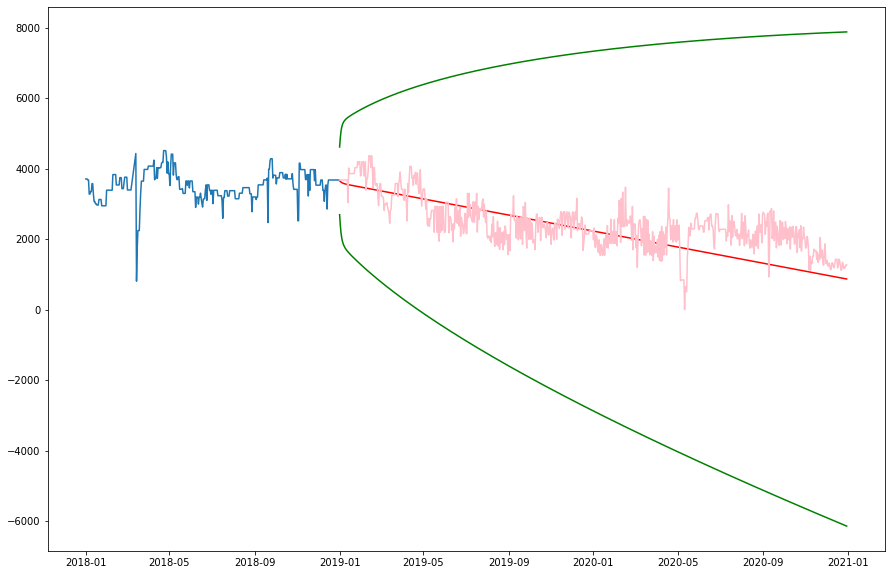

In [276]:
plt.plot(GasVol[-365:])
plt.plot(pronosticosGasVol, color='red')
plt.plot(ICforecast95['lower GasVol'],color='green')
plt.plot(ICforecast95['upper GasVol'], color='green')
plt.plot(datos.loc['2019-01-1':'2020-12-30','GasVol'], color = 'pink')


## Volumen de agua extraida

In [280]:
WaterVol = datos.loc['2013-01-01':'2018-12-31','WaterVol']

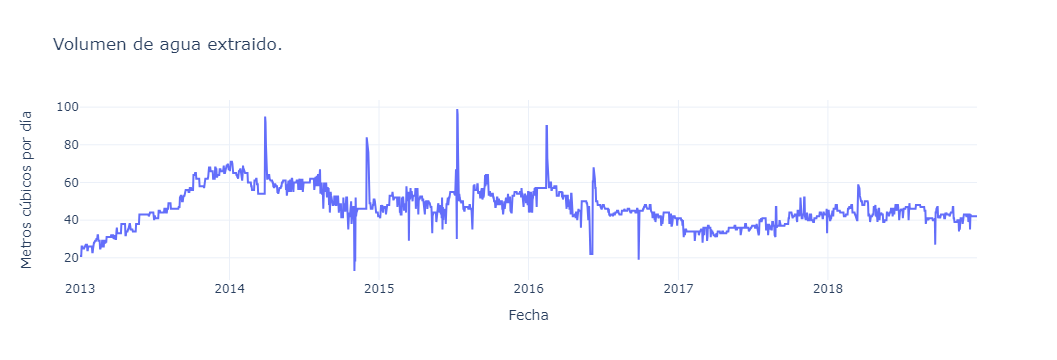

In [281]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y= WaterVol)])
fig.update_layout(title_text="Volumen de agua extraido.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos por día',template = "plotly_white")


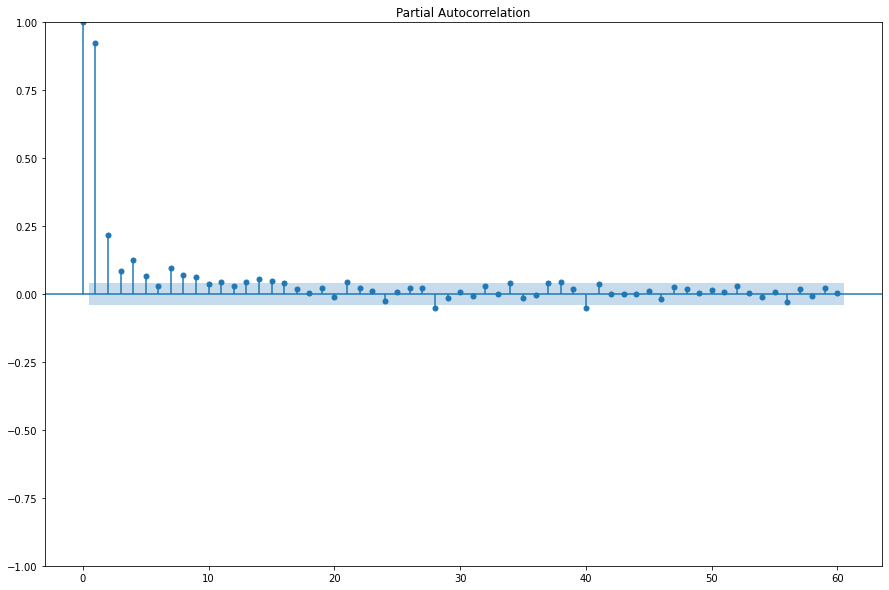

In [283]:
plot_pacf(WaterVol, lags=60)
plt.show()

### Modelado ARIMA

In [311]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(WaterVol,maxlag=16,regression='n',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(WaterVol,regression="n",maxlag=16,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -0.281892
P-value: 0.583037
	1%: -2.567
	5%: -1.941
	10%: -1.617


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.143
Model:                            OLS   Adj. R-squared (uncentered):              0.136
Method:                 Least Squares   F-statistic:                              21.15
Date:                Fri, 01 Nov 2024   Prob (F-statistic):                    1.18e-60
Time:                        17:16:10   Log-Likelihood:                         -5868.2
No. Observations:                2174   AIC:                                  1.177e+04
Df Residuals:                    2157   BIC:                                  1.187e+04
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0005      0.002     -0.282      0.778      -0.004       0.003
x2            -0.3544      0.022    -16.425      0.000      -0.397      -0.312
x3            -0.2286      0.023    -10.005      0.000      -0.273      -0.184
x4            -0.2518      0.023    -10.803      0.000      -0.298      -0.206
x5            -0.1806      0.024     -7.580      0.000      -0.227      -0.134
x6            -0.1561      0.024     -6.496      0.000      -0.203      -0.109
x7            -0.2086      0.024     -8.626      0.000      -0.256      -0.161
x8            -0.1709      0.024     -6.984      0.000      -0.219      -0.123
x9            -0.1511      0.025     -6.144      0.000      -0.199      -0.103
x10           -0.1206      0.025     -4.905      0.000      -0.169      -0.072
x11           -0.1173      0.024     -4.798      0.000      -0.165      -0.069
x12           -0.0950      0.024     -3.929      0.000      -0.142      -0.048
x13           -0.1038      0.024     -4.322      0.000      -0.151      -0.057
x14           -0.1011      0.024     -4.250      0.000      -0.148      -0.054
x15           -0.0790      0.023     -3.398      0.001      -0.125      -0.033
x16           -0.0562      0.023     -2.466      0.014      -0.101      -0.012
x17           -0.0250      0.022     -1.162      0.245      -0.067       0.017
==============================================================================
Omnibus:                     1961.119   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           374908.277
Skew:                           3.587   Prob(JB):                         0.00
Kurtosis:                      66.932   Cond. No.                         31.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Con una confianza del 95% no rechazamos la hipóteis nula; se confirma la presencia de raíz unitaria.
Por lo tanto se realiza la diferencia de primer orden de la serie para luego ajustar un modelo **ARMA(p,q)**

In [312]:
WaterVold = WaterVol.diff()
WaterVold.dropna(inplace=True)

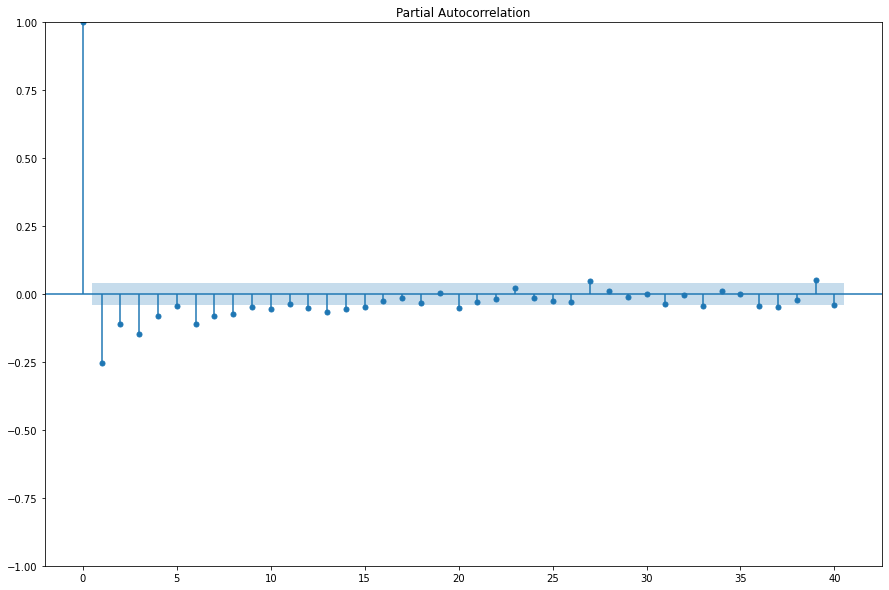

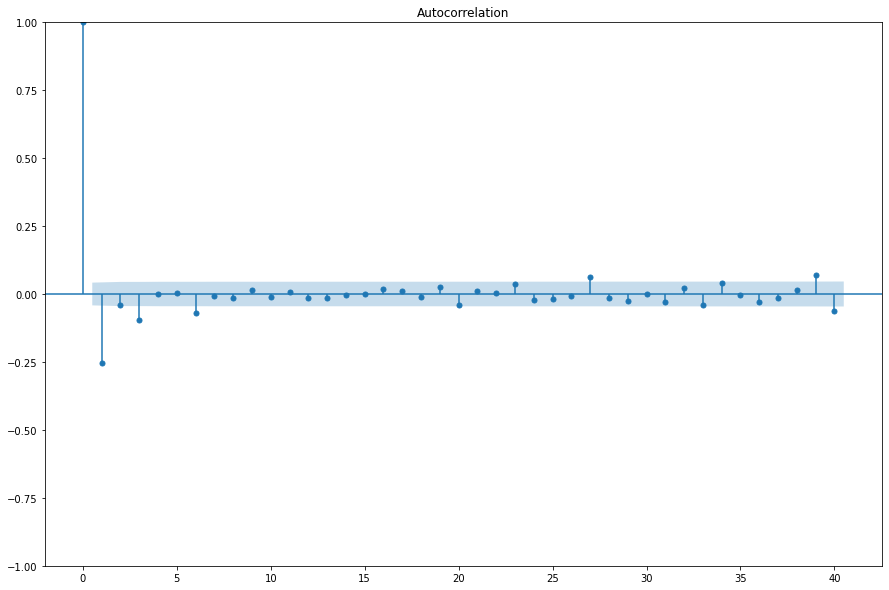

In [313]:
plot_pacf(WaterVold, lags=40)
plot_acf(WaterVold, lags=40)
plt.show()

Ya se puede ver que la PACF de la serie decrece muy rápido a 0. La ACF parece no mostrar signos de estacionalidad.

Se volve a realizar la prueba de Dickey y Fuller para determinar si hay que diferenciar de nuevo la serie.

In [314]:
from pmdarima.arima import auto_arima

adf = adfuller(WaterVold,maxlag=15,regression='n',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
adfstat, pvalue, critvalues, resstore=adfuller(WaterVold,regression="n",maxlag=15,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -17.315994
P-value: 0.000000
	1%: -2.567
	5%: -1.941
	10%: -1.617


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.658
Model:                            OLS   Adj. R-squared (uncentered):              0.656
Method:                 Least Squares   F-statistic:                              259.6
Date:                Fri, 01 Nov 2024   Prob (F-statistic):                        0.00
Time:                        17:16:35   Log-Likelihood:                         -5868.2
No. Observations:                2174   AIC:                                  1.177e+04
Df Residuals:                    2158   BIC:                                  1.186e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.4047      0.197    -17.316      0.000      -3.790      -3.019
x2             2.0500      0.190     10.797      0.000       1.678       2.422
x3             1.8209      0.181     10.042      0.000       1.465       2.177
x4             1.5687      0.172      9.127      0.000       1.232       1.906
x5             1.3877      0.162      8.588      0.000       1.071       1.705
x6             1.2312      0.151      8.167      0.000       0.936       1.527
x7             1.0223      0.139      7.336      0.000       0.749       1.296
x8             0.8511      0.127      6.686      0.000       0.601       1.101
x9             0.6997      0.115      6.100      0.000       0.475       0.925
x10            0.5788      0.102      5.685      0.000       0.379       0.778
x11            0.4612      0.089      5.191      0.000       0.287       0.635
x12            0.3660      0.076      4.804      0.000       0.217       0.515
x13            0.2620      0.063      4.151      0.000       0.138       0.386
x14            0.1607      0.050      3.242      0.001       0.063       0.258
x15            0.0815      0.036      2.252      0.024       0.011       0.152
x16            0.0251      0.022      1.167      0.243      -0.017       0.067
==============================================================================
Omnibus:                     1960.525   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           374574.708
Skew:                           3.585   Prob(JB):                         0.00
Kurtosis:                      66.904   Cond. No.                         62.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Se rechaza la hipótesis nula de presencia de raíz unitaria; no hay que diferenciar más la serie.

Se ajustará el modelo **ARMA(p,q)** a la serie de primer diferencia ordinaria.

Con base en la PACF Y ACF de la serie diferenciada podemos establecer los ordenes máximo del modelo. Para la parte AR tenemos que **p=15** y para la parte MA establecemos **q=5**

In [315]:
auto_WaterVol = auto_arima(WaterVold,start_p=0,d=0, start_q= 0, max_p=15, max_q=5, max_order=15,
                         seasonal=False,information_criterion='aic')

In [316]:
auto_WaterVol.order

(2, 0, 2)

El "mejor" modelo ARMA que minimiza el criterio AIC resulta ser un modelo ARMA(2,2). Por lo tanto se puede establecer el modelo ARIMA(3,1,1).

In [317]:
import statsmodels.api as smapi
WaterVolARIMA = smapi.tsa.SARIMAX(WaterVol,order=(2,1,2),trend='n')

In [318]:
ajusteWaterVol = WaterVolARIMA.fit()

Realizamos la predicción a un año con un intervalo de predicción al 95% 

In [319]:
salforecast=ajusteWaterVol.get_forecast(steps=365 * 2)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticosWaterVol=salforecast.predicted_mean
print(pronosticosWaterVol)
print(ICforecast95)

2019-01-01    41.950557
2019-01-02    41.922309
2019-01-03    41.901097
2019-01-04    41.887956
2019-01-05    41.878650
                ...    
2020-12-26    41.860243
2020-12-27    41.860243
2020-12-28    41.860243
2020-12-29    41.860243
2020-12-30    41.860243
Freq: D, Name: predicted_mean, Length: 730, dtype: float64
            lower WaterVol  upper WaterVol
2019-01-01       34.914791       48.986324
2019-01-02       33.561046       50.283571
2019-01-03       32.716573       51.085620
2019-01-04       32.266769       51.509143
2019-01-05       31.949869       51.807432
...                    ...             ...
2020-12-26        2.713045       81.007441
2020-12-27        2.687769       81.032717
2020-12-28        2.662509       81.057977
2020-12-29        2.637265       81.083221
2020-12-30        2.612038       81.108448

[730 rows x 2 columns]


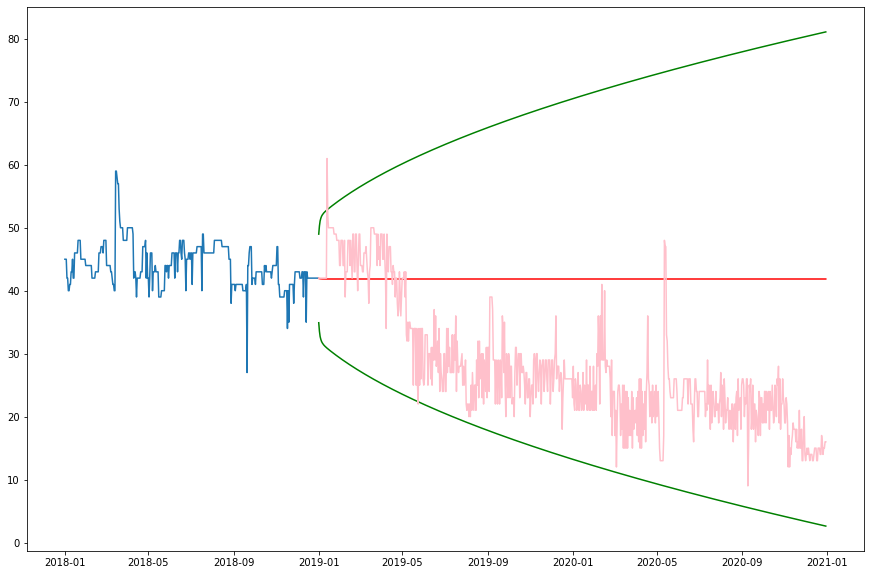

In [320]:
plt.plot(WaterVol[-365:])
plt.plot(pronosticosWaterVol, color='red')
plt.plot(ICforecast95['lower WaterVol'],color='green')
plt.plot(ICforecast95['upper WaterVol'], color='green')
plt.plot(datos.loc['2019-01-1':'2020-12-30','WaterVol'], color = 'pink')


## Porcentaje de agua en líquido

In [277]:
datos.info

<bound method DataFrame.info of             OilVol  VolLiq   GasVol  WaterVol  WaterCut  WorkHours  DnmcLvl  \
2013-01-01    49.0    70.0  13055.0      21.0      29.0       24.0   1819.0   
2013-01-02    49.0    70.0  13055.0      21.0      29.0       24.0   1836.0   
2013-01-03    49.0    70.0  13055.0      21.0      29.0       24.0   1788.0   
2013-01-04    49.0    70.0  13055.0      21.0      29.0       24.0   1789.0   
2013-01-05    44.0    70.0  11768.0      26.0      36.0       24.0   1825.0   
...            ...     ...      ...       ...       ...        ...      ...   
2021-01-13     5.0    18.0   1408.0      13.0      70.0       15.0   2113.0   
2021-01-14     6.0    20.0   1593.0      15.0      70.0       16.0   2101.0   
2021-01-15     6.0    20.0   1593.0      15.0      70.0       16.0   2113.0   
2021-01-16     6.0    20.0   1583.0      14.0      70.0       16.0   2125.0   
2021-01-17     6.0    20.0   1573.0      14.0      70.0       16.0   2125.0   

            Pressur

In [321]:
WaterCut = datos.loc['2013-01-01':'2018-12-31','WaterCut']

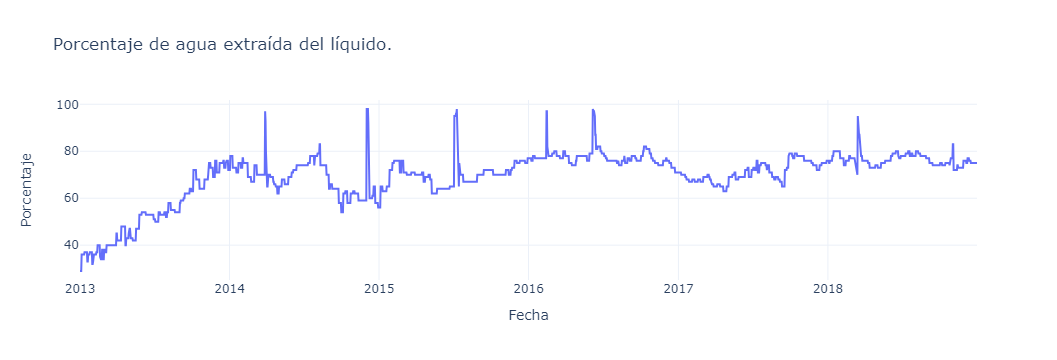

In [323]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y= WaterCut)])
fig.update_layout(title_text="Porcentaje de agua extraída del líquido.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Porcentaje',template = "plotly_white")


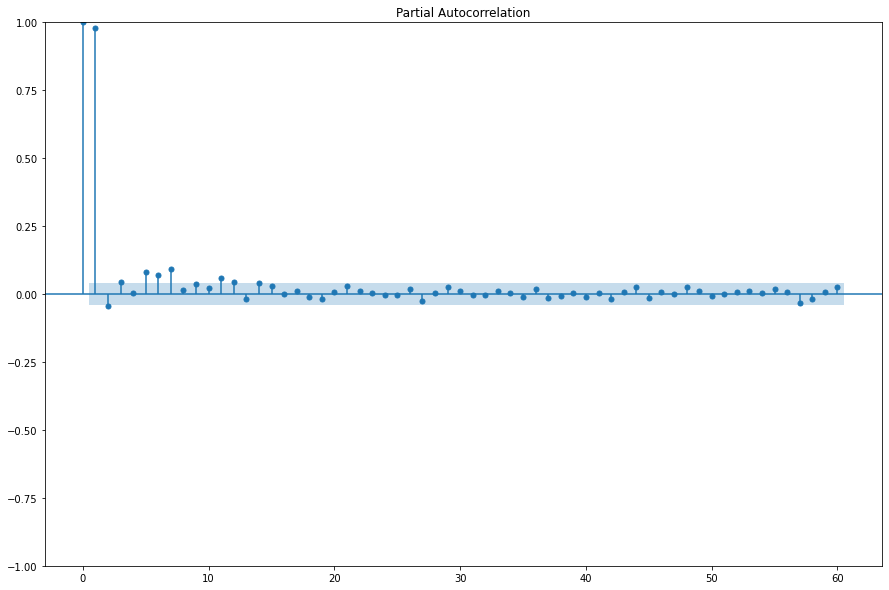

In [324]:
plot_pacf(WaterCut, lags=60)
plt.show()

### Modelado ARIMA

In [328]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(WaterCut,maxlag=14,regression='n',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(WaterCut,regression="n",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: 0.295352
P-value: 0.773604
	1%: -2.567
	5%: -1.941
	10%: -1.617


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.052
Model:                            OLS   Adj. R-squared (uncentered):              0.045
Method:                 Least Squares   F-statistic:                              7.885
Date:                Fri, 01 Nov 2024   Prob (F-statistic):                    1.41e-17
Time:                        17:20:21   Log-Likelihood:                         -4538.9
No. Observations:                2176   AIC:                                      9108.
Df Residuals:                    2161   BIC:                                      9193.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002      0.001      0.295      0.768      -0.001       0.001
x2             0.0084      0.022      0.392      0.695      -0.034       0.051
x3            -0.0960      0.021     -4.470      0.000      -0.138      -0.054
x4            -0.0454      0.022     -2.106      0.035      -0.088      -0.003
x5            -0.1044      0.022     -4.847      0.000      -0.147      -0.062
x6            -0.1153      0.022     -5.339      0.000      -0.158      -0.073
x7            -0.1376      0.022     -6.341      0.000      -0.180      -0.095
x8            -0.0457      0.022     -2.091      0.037      -0.089      -0.003
x9            -0.0700      0.022     -3.203      0.001      -0.113      -0.027
x10           -0.0468      0.022     -2.154      0.031      -0.089      -0.004
x11           -0.0790      0.022     -3.661      0.000      -0.121      -0.037
x12           -0.0658      0.021     -3.066      0.002      -0.108      -0.024
x13            0.0079      0.021      0.369      0.712      -0.034       0.050
x14           -0.0558      0.021     -2.609      0.009      -0.098      -0.014
x15           -0.0430      0.021     -2.006      0.045      -0.085      -0.001
==============================================================================
Omnibus:                     3087.805   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1802924.957
Skew:                           7.887   Prob(JB):                         0.00
Kurtosis:                     143.130   Cond. No.                         50.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Con una confianza del 95% no rechazamos la hipóteis nula; se confirma la presencia de raíz unitaria.
Por lo tanto se realiza la diferencia de primer orden de la serie para luego ajustar un modelo **ARMA(p,q)**

In [329]:
WaterCutd = WaterCut.diff()
WaterCutd.dropna(inplace=True)

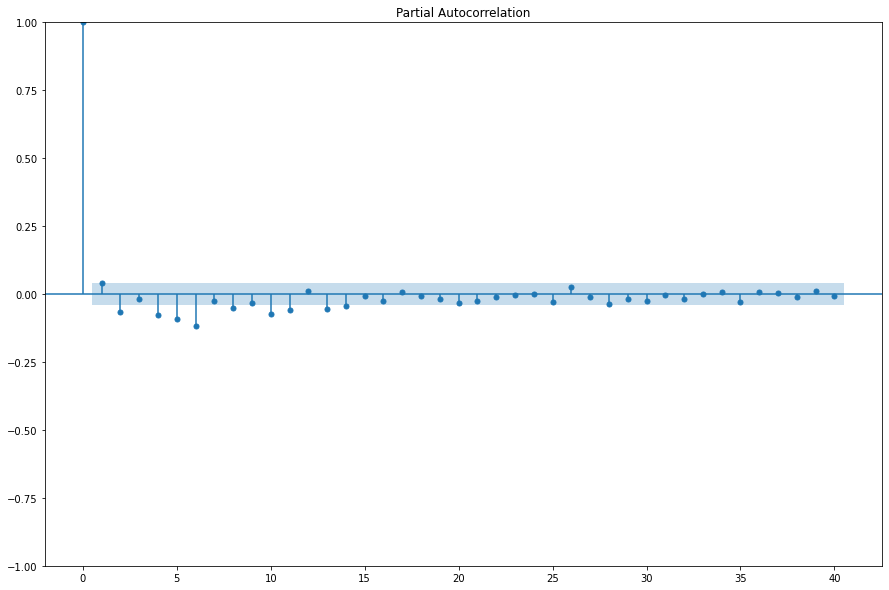

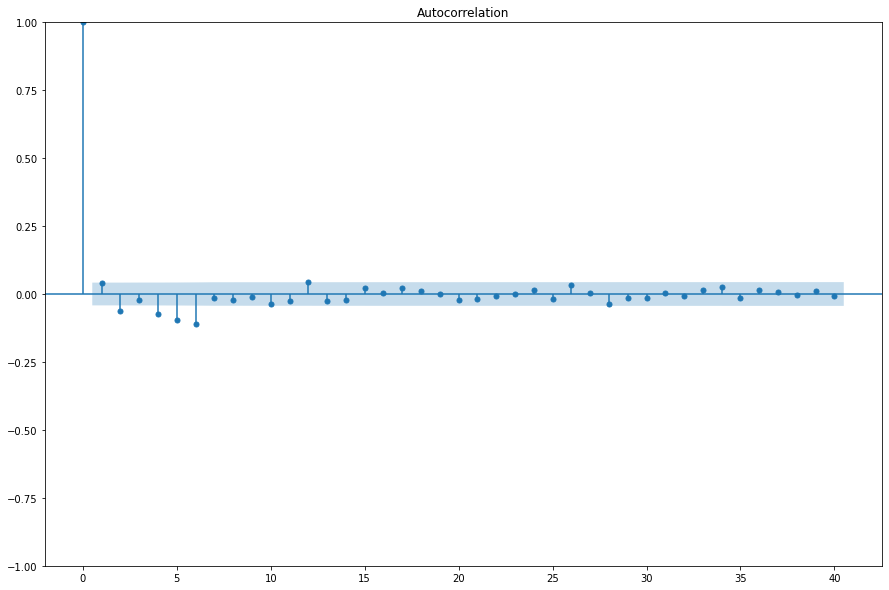

In [330]:
plot_pacf(WaterCutd, lags=40)
plot_acf(WaterCutd, lags=40)
plt.show()

Ya se puede ver que la PACF de la serie decrece muy rápido a 0. La ACF parece no mostrar signos de estacionalidad.

Se volve a realizar la prueba de Dickey y Fuller para determinar si hay que diferenciar de nuevo la serie.

In [331]:
from pmdarima.arima import auto_arima

adf = adfuller(WaterCutd,maxlag=14,regression='n',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
adfstat, pvalue, critvalues, resstore=adfuller(WaterCutd,regression="n",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -16.141797
P-value: 0.000000
	1%: -2.567
	5%: -1.941
	10%: -1.617


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.506
Model:                            OLS   Adj. R-squared (uncentered):              0.502
Method:                 Least Squares   F-statistic:                              147.4
Date:                Fri, 01 Nov 2024   Prob (F-statistic):                   7.18e-317
Time:                        17:21:44   Log-Likelihood:                         -4537.3
No. Observations:                2175   AIC:                                      9105.
Df Residuals:                    2160   BIC:                                      9190.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.9019      0.118    -16.142      0.000      -2.133      -1.671
x2             0.9102      0.112      8.109      0.000       0.690       1.130
x3             0.8139      0.107      7.624      0.000       0.605       1.023
x4             0.7688      0.101      7.606      0.000       0.571       0.967
x5             0.6640      0.095      7.003      0.000       0.478       0.850
x6             0.5482      0.088      6.206      0.000       0.375       0.721
x7             0.4103      0.082      5.022      0.000       0.250       0.571
x8             0.3642      0.075      4.883      0.000       0.218       0.510
x9             0.2940      0.067      4.367      0.000       0.162       0.426
x10            0.2463      0.060      4.135      0.000       0.129       0.363
x11            0.1665      0.052      3.187      0.001       0.064       0.269
x12            0.0995      0.045      2.206      0.027       0.011       0.188
x13            0.1072      0.038      2.816      0.005       0.033       0.182
x14            0.0507      0.030      1.681      0.093      -0.008       0.110
x15            0.0079      0.021      0.370      0.712      -0.034       0.050
==============================================================================
Omnibus:                     3086.613   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1801678.090
Skew:                           7.888   Prob(JB):                         0.00
Kurtosis:                     143.113   Cond. No.                         26.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Se rechaza la hipótesis nula de presencia de raíz unitaria; no hay que diferenciar más la serie.

Se ajustará el modelo **ARMA(p,q)** a la serie de primer diferencia ordinaria.

Con base en la PACF Y ACF de la serie diferenciada podemos establecer los ordenes máximo del modelo. Para la parte AR tenemos que **p=15** y para la parte MA establecemos **q=5**

In [332]:
auto_WaterCut = auto_arima(WaterCutd,start_p=0,d=0, start_q= 0, max_p=15, max_q=6, max_order=15,
                         seasonal=False,information_criterion='aic')

In [333]:
auto_WaterCut.order

(4, 0, 3)

El "mejor" modelo ARMA que minimiza el criterio AIC resulta ser un modelo ARMA(4,3). Por lo tanto se puede establecer el modelo ARIMA(4,1,3).

In [334]:
import statsmodels.api as smapi
WaterCutARIMA = smapi.tsa.SARIMAX(WaterCut,order=(4,1,3),trend='n')

In [335]:
ajusteWaterCut = WaterCutARIMA.fit()

Realizamos la predicción a un año con un intervalo de predicción al 95% 

In [336]:
salforecast=ajusteWaterCut.get_forecast(steps=365 * 2)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticosWaterCut=salforecast.predicted_mean
print(pronosticosWaterCut)
print(ICforecast95)

2019-01-01    75.013733
2019-01-02    75.019110
2019-01-03    75.032719
2019-01-04    75.055153
2019-01-05    75.070736
                ...    
2020-12-26    75.093537
2020-12-27    75.093537
2020-12-28    75.093537
2020-12-29    75.093537
2020-12-30    75.093537
Freq: D, Name: predicted_mean, Length: 730, dtype: float64
            lower WaterCut  upper WaterCut
2019-01-01       71.191029       78.836438
2019-01-02       69.604621       80.433598
2019-01-03       68.614237       81.451201
2019-01-04       67.865755       82.244551
2019-01-05       67.318308       82.823163
...                    ...             ...
2020-12-26       35.447009      114.740066
2020-12-27       35.420790      114.766285
2020-12-28       35.394589      114.792486
2020-12-29       35.368405      114.818670
2020-12-30       35.342238      114.844837

[730 rows x 2 columns]


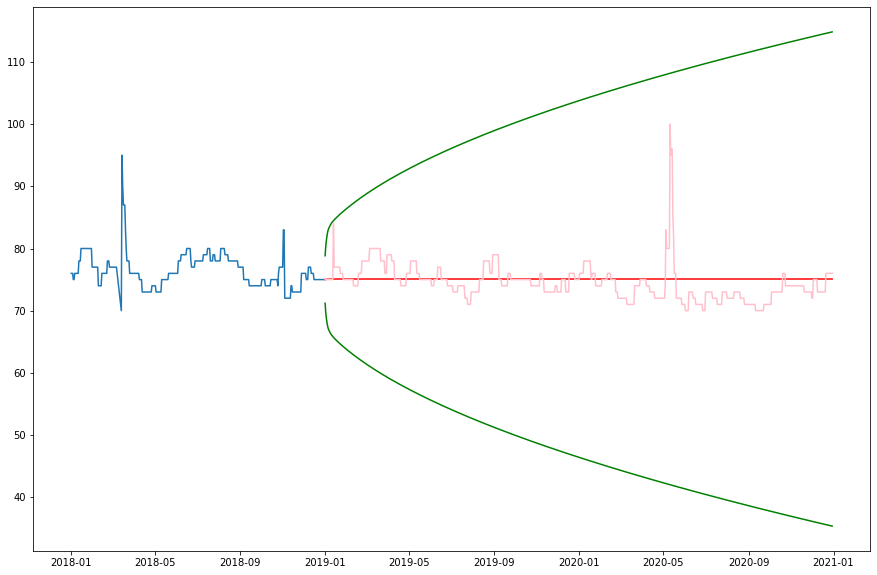

In [337]:
plt.plot(WaterCut[-365:])
plt.plot(pronosticosWaterCut, color='red')
plt.plot(ICforecast95['lower WaterCut'],color='green')
plt.plot(ICforecast95['upper WaterCut'], color='green')
plt.plot(datos.loc['2019-01-1':'2020-12-30','WaterCut'], color = 'pink')


## Exportación de pronósticos.

In [338]:
type(pronosticos)

pandas.core.series.Series